Exercise 1

In [1]:
# !conda create --name old_qiskit python=3.8
# !y
# !conda activate old_qiskit
# !pip install qiskit==1.1.1 qutip
# !pip install qutip_qip matplotlib tqdm

In [2]:
# ! python -m pip install "qiskit-experiments[extras]"
# ! pip install pylatexenc


In [3]:
import copy
import random
import uuid
from collections import Counter
from typing import Any, Dict, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.library import CZGate, RXGate, RZGate
from qiskit.providers import BackendV1, BackendV2, Options
from qiskit.providers.models import QasmBackendConfiguration
from qiskit.providers.provider import ProviderV1
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.qobj import QobjExperimentHeader
from qiskit.result import Counts, Result
from qiskit.result.models import ExperimentResult, ExperimentResultData
from qiskit.transpiler import Target
from qiskit.visualization import plot_histogram
from qiskit_experiments.framework import BatchExperiment, ParallelExperiment
from qiskit_experiments.library import InterleavedRB, StandardRB

import qutip
from qutip import (Bloch, Qobj, basis, fidelity, identity, mesolve, rand_unitary,
                   sigmax, sigmay, sigmaz, tensor)
from qutip_qip.circuit import QubitCircuit
from qutip_qip.circuit.circuitsimulator import CircuitResult
from qutip_qip.device import Model, Processor
from qutip_qip.operations import cz_gate, expand_operator, rx, ry, rz
from qutip_qip.qiskit import QiskitCircuitSimulator, QiskitPulseSimulator, QiskitSimulatorBase
from qutip_qip.qiskit.converter import convert_qiskit_circuit
from qutip_qip.qiskit.job import Job

In [4]:
class MyQiskitSimulatorBase(BackendV1):
    """
    The base class for ``qutip_qip`` based ``qiskit`` backends.
    """

    def __init__(self, configuration=None, **fields):
        if configuration is None:
            configuration_dict = self._DEFAULT_CONFIGURATION
        else:
            configuration_dict = self._DEFAULT_CONFIGURATION.copy()
            for k, v in configuration.items():
                configuration_dict[k] = v

        configuration = QasmBackendConfiguration.from_dict(configuration_dict)

        super().__init__(configuration=configuration)

        self.options.set_validator(
            "shots", (1, self.configuration().max_shots)
        )

    def run(self, qiskit_circuit: QuantumCircuit, **run_options) -> Job:
        """
        Simulates a circuit on the required backend.

        Parameters
        ----------
        qiskit_circuit : :class:`qiskit.circuit.QuantumCircuit`
            The ``qiskit`` circuit to be simulated.

        **run_options:
            Additional run options for the backend.

            Valid options are:

            shots : int
                Number of times to sample the results.
            allow_custom_gate: bool
                Allow conversion of circuit using unitary matrices
                for custom gates.

        Returns
        -------
        :class:`.Job`
            Job object that stores results and execution data.
        """
        # configure the options
        self.set_options(
            shots=(
                run_options["shots"]
                if "shots" in run_options
                else self._default_options().shots
            ),
            allow_custom_gate=(
                run_options["allow_custom_gate"]
                if "allow_custom_gate" in run_options
                else self._default_options().allow_custom_gate
            ),
        )
        
        # qutip_circ = convert_qiskit_circuit(
        #     qiskit_circuit,
        #     allow_custom_gate=self.options.allow_custom_gate,
        # )

        job_id = str(uuid.uuid4())

        # job = Job(
        #     backend=self,
        #     job_id=job_id,
        #     result=self._run_job(job_id, qutip_circ),
        # )
        job = Job(
            backend=self,
            job_id=job_id,
            result=self._run_job(job_id, qiskit_circuit),
        )
        return job

    def _sample_shots(self, count_probs: dict) -> Counts:
        """
        Sample measurements from a given probability distribution.

        Parameters
        ----------
        count_probs: dict
            Probability distribution corresponding
            to different classical outputs.

        Returns
        -------
        :class:`qiskit.result.Counts`
            Returns the ``Counts`` object sampled according to
            the given probabilities and configured shots.
        """
        shots = self.options.shots
        samples = random.choices(
            list(count_probs.keys()), list(count_probs.values()), k=shots
        )
        return Counts(Counter(samples))

    def _get_probabilities(self, state):
        """
        Given a state, return an array of corresponding probabilities.
        """
        if state.type == "oper":
            # diagonal elements of a density matrix are
            # the probabilities
            return state.diag()

        # squares of coefficients are the probabilities
        # for a ket vector
        return np.array([np.abs(coef) ** 2 for coef in state])

class MyQiskitPulseSimulator(MyQiskitSimulatorBase):
    """
    ``qiskit`` backend dealing with pulse-level simulation.

    Parameters
    ----------
    processor : :class:`.Processor`
        The processor model to be used for simulation.
        An instance of the required :class:`.Processor`
        object is to be provided after initialising
        it with the required parameters.

    configuration : dict
        Configurable attributes of the backend.

    Attributes
    ----------
    processor : :class:`.Processor`
        The processor model to be used for simulation.
    """

    processor = None
    MAX_QUBITS_MEMORY = 10
    BACKEND_NAME = "pulse_simulator"
    _DEFAULT_CONFIGURATION = {
        "backend_name": BACKEND_NAME,
        "backend_version": "0.1",
        "n_qubits": MAX_QUBITS_MEMORY,
        "url": "https://github.com/qutip/qutip-qip",
        "simulator": True,
        "local": True,
        "conditional": False,
        "open_pulse": False,
        "memory": False,
        "max_shots": int(1e6),
        "coupling_map": None,
        "description": "A qutip-qip based pulse-level \
            simulator based on the open system solver.",
        "basis_gates": [],
        "gates": [],
    }

    def __init__(self, processor: Processor, configuration=None, **fields):
        self.processor = processor
        super().__init__(configuration=configuration, **fields)

    def _parse_results(
        self, final_state: qutip.Qobj, job_id: str, qutip_circuit: QubitCircuit
    ) -> qiskit.result.Result:
        """
        Returns a parsed object of type :class:`qiskit.result.Result`
        for the pulse simulators.

        Parameters
        ----------
        density_matrix : :class:`.Qobj`
            The resulting density matrix obtained from `run_state` on
            a circuit using the Pulse simulator processors.

        job_id : str
            Unique ID identifying a job.

        qutip_circuit : :class:`.QubitCircuit`
            The circuit being simulated.

        Returns
        -------
        :class:`qiskit.result.Result`
            Result of the pulse simulation.
        """
        count_probs = {}
        counts = None

        # calculate probabilities of required states
        if final_state:
            for i, prob in enumerate(self._get_probabilities(final_state)):
                if not np.isclose(prob, 0):
                    count_probs[hex(i)] = prob
            # sample the shots from obtained probabilities
            counts = self._sample_shots(count_probs)

        exp_res_data = ExperimentResultData(
            counts=counts,
            statevector=(
                Statevector(data=final_state.full())
                if final_state.type == "ket"
                else DensityMatrix(data=final_state.full())
            ),
        )

        header = QobjExperimentHeader.from_dict(
            {
                "name": (
                    qutip_circuit.name
                    if hasattr(qutip_circuit, "name")
                    else ""
                ),
                "n_qubits": qutip_circuit.N,
            }
        )

        exp_res = ExperimentResult(
            shots=self.options.shots,
            success=True,
            data=exp_res_data,
            header=header,
        )

        result = Result(
            backend_name=self.configuration().backend_name,
            backend_version=self.configuration().backend_version,
            qobj_id=id(qutip_circuit),
            job_id=job_id,
            success=True,
            results=[exp_res],
        )

        return result

    def _run_job(self, job_id: str, 
                #  qutip_circuit: QubitCircuit
                qiskit_circuit: QuantumCircuit
                 ) -> Result:
        """
        Run a :class:`.QubitCircuit` on the Pulse Simulator.

        Parameters
        ----------
        job_id : str
            Unique ID identifying a job.

        qutip_circuit : :class:`.QubitCircuit`
            The circuit obtained after conversion
            from :class:`.QuantumCircuit` to :class:`.QubitCircuit`.

        Returns
        -------
        :class:`qiskit.result.Result`
            Result of the simulation.
        """
        zero_state = self.processor.generate_init_processor_state()

        # self.processor.load_circuit(qutip_circuit)
        self.processor.load_circuit(qiskit_circuit)
        result = self.processor.run_state(zero_state)

        if not isinstance(result,list):
            final_state = self.processor.get_final_circuit_state(result.states[-1])

            qutip_circ = convert_qiskit_circuit(
                qiskit_circuit,
                allow_custom_gate=self.options.allow_custom_gate,
            )
            qutip_circ.N = self.processor.num_qubits

            return self._parse_results(
                final_state=final_state, job_id=job_id, qutip_circuit=qutip_circ
            )
        else:
            parsed_results = []
            for res,circ in zip(result,qiskit_circuit):
                final_state = self.processor.get_final_circuit_state(res.states[-1])
                qutip_circ = convert_qiskit_circuit(
                    circ,
                    allow_custom_gate=self.options.allow_custom_gate,
                )
                circ.N = self.processor.num_qubits
                parsed_results.append(self._parse_results(final_state=final_state, job_id=job_id, qutip_circuit=circ))
            return parsed_results

    @classmethod
    def _default_options(cls):
        """
        Default options for the backend.

        Options
        -------
        shots : int
            Number of times to sample the results.

        allow_custom_gate : bool
            Allow conversion of circuit using unitary matrices
            for custom gates.
        """
        return Options(shots=1024, allow_custom_gate=True)

GROUND = basis(4, 0)
EXCITED = basis(4, 1)
LEAKAGE = basis(4, 2)
RYDBERG = basis(4, 3)


class minimal_processor(Processor):
    def __init__(self,
                 num_qubits=2,
                 Omega_01 = 9.999385781382449,
                 delta_1 = -9.997619824080692,
                 gamma_r = 0,# 1 / 540
                 ):
        self.Omega_01 = Omega_01
        self.delta_1= delta_1
        self.basis_gates=['rx','rz','cz']
        self.qbt_dim=4
        self.model=Model(num_qubits=num_qubits,
                         dims=[self.qbt_dim for _ in range(num_qubits)])
        self.num_qubits=num_qubits
        self.get_c_ops(gamma_r)

    def evolve(self, state: qutip.Qobj, name: str, param: Optional[float], qbts: List[int]):
        if name == 'rx':
            return self._evolve_rx(state, param, qbts)
        elif name == 'rz':
            return self._evolve_rz(state, param, qbts)
        elif name == 'cz':
            return self._evolve_cz(state, qbts)
        # else:
        #     raise ValueError(f"Unsupported gate: {name}")

    def _evolve_rx(self, state: qutip.Qobj, param: float, qbts: List[int]):
        Omega_01 = self.Omega_01
        return mesolve(
            H=self.id_wrap(Omega_01 / 2 * (GROUND * EXCITED.dag() + EXCITED * GROUND.dag()), qbts[0]),
            rho0=state,
            tlist=np.array([0, param / 10]),
            c_ops=self.collapse_ops,
            options={'store_final_state': True}
        )

    def _evolve_rz(self, state: qutip.Qobj, param: float, qbts: List[int]):
        delta_1 = self.delta_1
        H = self.id_wrap(delta_1 * EXCITED * EXCITED.dag(), qbts[0])
        return mesolve(
            H=H,
            rho0=state,
            tlist=np.array([0, param / 10]),
            c_ops=self.collapse_ops,
            options={'store_final_state': True}
        )

    def _evolve_cz(self, state: qutip.Qobj, qbts: List[int]):
        t_tot = 0.540  # microsecond, which is the total duration of the gate protocol
        B = 200 * 2 * np.pi  # interaction strength
        omegaMax = 17 * 2 * np.pi  # MHz
        deltaMax = 23 * 2 * np.pi  # MHz
        tau = 0.175 * t_tot
        a = np.exp(-(t_tot / 4) ** 4 / tau ** 4)

        def Rabi_frequency(t, args):
            return (t < t_tot / 2) * omegaMax * (np.exp(-(t - t_tot / 4) ** 4 / tau ** 4) - a) / (1 - a) + \
                   (t >= t_tot / 2) * omegaMax * (np.exp(-(t - 3 * t_tot / 4) ** 4 / tau ** 4) - a) / (1 - a)

        def Detunning(t, args):
            return (t < t_tot / 2) * (-1) * deltaMax * np.cos(2 * np.pi * t / t_tot) + \
                   (t >= t_tot / 2) * deltaMax * np.cos(2 * np.pi * t / t_tot)

        H = []
        for idx in qbts:
            H.append([self.id_wrap(0.5 * RYDBERG * EXCITED.dag() + 0.5 * EXCITED * RYDBERG.dag(), idx), Rabi_frequency])
            H.append([self.id_wrap(RYDBERG * RYDBERG.dag(), idx), Detunning])

        H.append(self.id_wrap(B * tensor(RYDBERG, RYDBERG) * tensor(RYDBERG, RYDBERG).dag(), qbts))  # This assumes the system involves two qubit only.

        state = self._evolve_rz(state, np.pi, [qbts[0]]).states[-1]
        state = mesolve(
            H=H,
            rho0=state,
            tlist=np.array([0, t_tot]),
            c_ops=self.collapse_ops,
            options={'store_final_state': True, 'nsteps': 10000}
        ).states[-1]
        return self._evolve_rz(state, np.pi, [qbts[1]])

    def invert_idx(self,idx):
        return self.num_qubits-1-idx        
    
    def run_state(self,
                  init_state:qutip.Qobj) -> qutip.solver.Result:
        # print('run_state called')
        if init_state.isket:
            assert init_state.dims == [[self.qbt_dim for _ in range(self.num_qubits)],[1 for _ in range(self.num_qubits)]]
        else:
            assert init_state.dims == [[self.qbt_dim for _ in range(self.num_qubits)],[self.qbt_dim for _ in range(self.num_qubits)]]
        state = copy.deepcopy(init_state)
        if isinstance(self.qiskit_circ_transpiled,QuantumCircuit):
            for ins in tqdm(self.qiskit_circ_transpiled.data,'Simulating gate'):
                # print(ins)
                name = ins.operation.name    
                param = next(iter(ins.operation.params), None)
                qbts = [self.invert_idx(qubit._index) for qubit in ins.qubits]
                if name in self.basis_gates:
                        result = self.evolve(state, name, param, qbts)            
                        state = result.final_state
            return result
        else:
            results = []
            for circ in tqdm(self.qiskit_circ_transpiled,'Simulating circuits') :
                for ins in tqdm(circ,'Simulating gate'):
                    name = ins.operation.name    
                    param = next(iter(ins.operation.params), None)
                    qbts = [self.invert_idx(qubit._index) for qubit in ins.qubits]
                    if name in self.basis_gates:
                        result = self.evolve(state, name, param, qbts)            
                        state = result.final_state
                results.append(result)
            return results
    def generate_init_processor_state(self)->qutip.Qobj:
        # Always initialize in zero
        return tensor([basis(self.qbt_dim, 0) for _ in range(self.num_qubits)])
    
    def id_wrap(self,
                op:qutip.Qobj,
                idx:Union[int,List[int]])->qutip.Qobj:
        if isinstance(idx,int):
            idx = [idx]
        return expand_operator(oper=op,
                               dims=[self.qbt_dim for _ in range(self.num_qubits)],
                               targets=idx)

    def get_c_ops(self,gamma_r):
        L0 = np.sqrt(1/16 * gamma_r) * (GROUND * RYDBERG.dag())
        L1 = np.sqrt(1/16 * gamma_r) * (EXCITED * RYDBERG.dag())
        Ld = np.sqrt(7/8 * gamma_r) * (LEAKAGE * RYDBERG.dag())
        single_q_c_ops = [L0, L1, Ld]

        self.collapse_ops = []
        for q in range(self.num_qubits):
            for c_op in single_q_c_ops:
                self.collapse_ops.append(self.id_wrap(c_op,
                                                      q))
    
    def load_circuit(self,
                     qiskit_circuit:qiskit.QuantumCircuit)->None:
        self.qiskit_circ_transpiled = transpile(qiskit_circuit,basis_gates=self.basis_gates)
        # self.qiskit_circ_transpiled = qiskit_circ_transpiled
    
    def get_final_circuit_state(self,state:qutip.Qobj)->qutip.Qobj:
        rho = state
        if rho.isket:
            rho = qutip.ket2dm(rho)
        rho_arr = rho.full()
        rho_reshaped = rho_arr.reshape(*[self.qbt_dim for _ in range(self.num_qubits*2)])
        # print(rho_reshaped.shape)
        rho_reshaped_2lvl = rho_reshaped[tuple(slice(0, 2) for _ in range(2 * self.num_qubits))]
        # print(rho_reshaped_2lvl.shape)
        return Qobj(rho_reshaped_2lvl.reshape(2**self.num_qubits , 2**self.num_qubits), dims=[[2] * self.num_qubits, [2] * self.num_qubits])
  

In [5]:
lengths=[1,2,3,4,5,6,7,8,9,10]
num_samples = 10
experiment = StandardRB([0,1], lengths=lengths, num_samples=num_samples, seed=2)
experiment.set_transpile_options(basis_gates=['rx','rz','cz','reset','measure','barrier'])
transpiled_circuits = experiment._transpiled_circuits()
names = [transpiled_circuits[circ_idx].data[ins_idx].operation.name for circ_idx in range(len(lengths)*num_samples) for ins_idx in range(len(transpiled_circuits[circ_idx].data))]
unique_names = np.unique(names)
unique_names

array(['barrier', 'cz', 'measure', 'rx', 'rz'], dtype='<U7')

In [6]:
processor = minimal_processor(2,gamma_r=0)
pulse_backend = MyQiskitPulseSimulator(processor)
results = pulse_backend.run(transpiled_circuits)

Simulating circuits: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


In [7]:
all_count_names = [
    key 
    for _ in range(len(results.result())) 
    for key in results.result()[_].results[0].data.counts.keys()
]
unique_keys = np.unique(all_count_names)
unique_keys

array(['0', '1', '10', '11'], dtype='<U2')

In [8]:
key_to_index = {key: i for i, key in enumerate(unique_keys)}
key_to_index

{'0': 0, '1': 1, '10': 2, '11': 3}

In [9]:
data_array = np.zeros((len(lengths)*num_samples, len(unique_keys)))
for i, d in enumerate([results.result()[idx].results[0].data.counts for idx in range(len(lengths)*num_samples)]):
    for key, value in d.items():
        data_array[i, key_to_index[key]] = value  # Assumes values are numeric

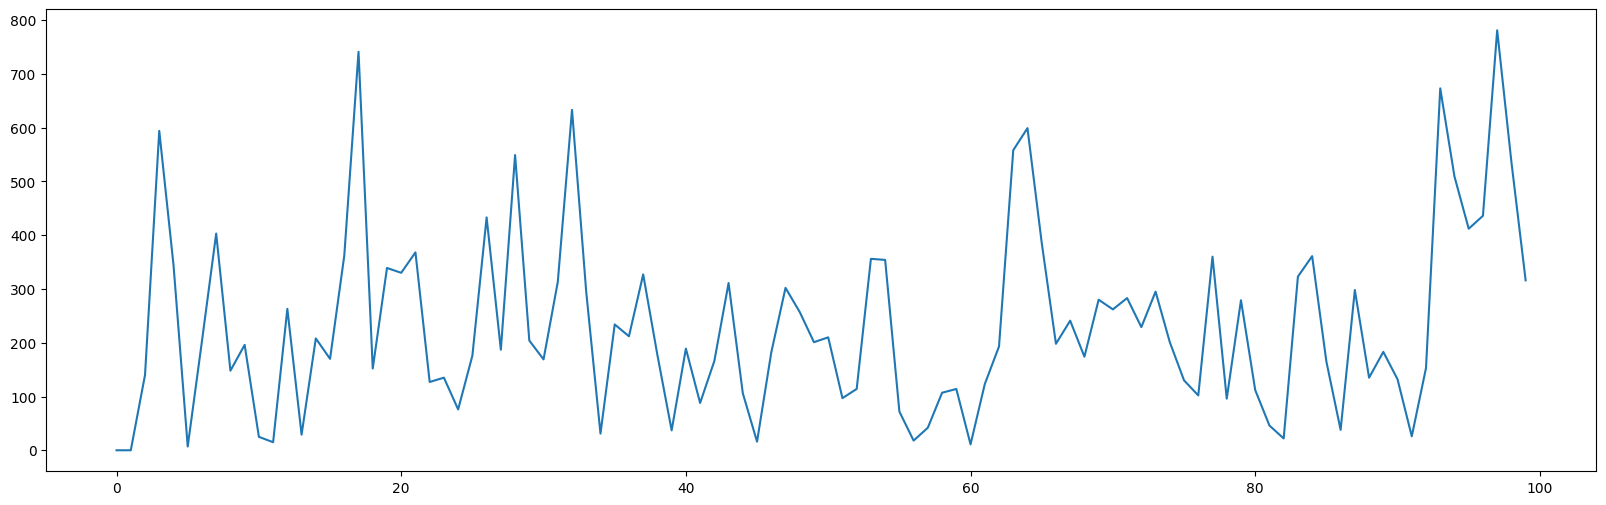

In [10]:
data_array_T = data_array.T
plt.figure(figsize=(20, 6))
for row in [data_array_T[3]]:
    plt.plot(np.arange(len(lengths)*num_samples),row)


Text(0, 0.5, 'Probability of measuing 00')

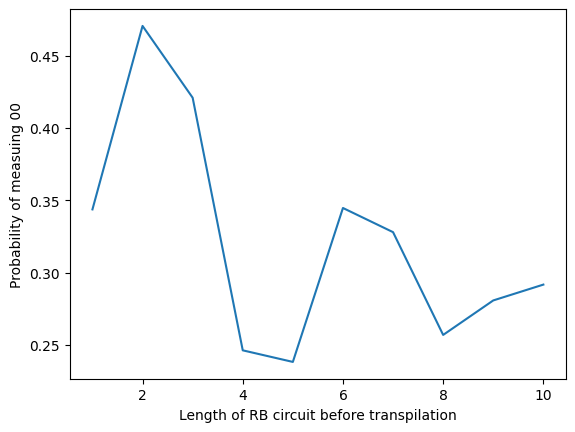

In [11]:
counts_list = np.zeros(len(lengths))
for i in range(len(lengths)):
    for j in range(num_samples):
        # idx = i*num_samples + j
        idx = j*len(lengths) + i
        counts_list[i] += results.result()[idx].results[0].data.counts.get('0',0)

counts_list = counts_list/num_samples/1024
plt.plot(lengths,counts_list)
plt.xlabel('Length of RB circuit before transpilation')
plt.ylabel('Probability of measuing 00')

# This is because the random circuit is compiled to too many rz, rx, cz ! 